# 1) GSP on the Digital Reconstruction of the Brain
### Stefania Ebli - Christopher Elin - Florian Roth

The goal of this project is to explore a digital reconstruction of the brain through graph signal processing techniques.

In 2015 the [Blue Brain Project](https://bluebrain.epfl.ch/) published the [first digital reconstruction](http://www.cell.com/cell/pdf/S0092-8674%2815%2901191-5.pdf) of the microcircuit of the somatosensory cortex of a juvenile rat. This reconstruction follows biological principles. In particular, it reproduces in detail the anatomy and the physiology of each neuron in the digital microcircuit. For example, it contains information about the electrical properties, morphological properties, synaptic properties and membrane properties of the neurons. A column (or microcolumn) of the microcircuit is
a neocortical volume of 0.29 ± 0.01 $mm^3$ containing ~31,000 neuron. Digitally reconstructed neurons are positioned in this volume according to experimentally based estimates of their densities in the 6 layers into which each microcolumn is divided. After their allocation in the 3D space, the connectivity between the neurons is reconstructed. Lastly, different stochastic instances of this microcolumn are initiated and assembled to simulate a defined volume in the somatosensory cortex.

The experimental data, the digital reconstruction, and the simulation results are available at [the Neocortical Microcircuit Collaboration
Portal](https://bbp.epfl.ch/nmc-portal). In the section Downloads one can find the data we used for this project. The connectivity of different instances of a modeled microcircuit are available as HDF5 files. For building our network we will use one of the 7 stochastic instances of a modeled microcircuit based on averaged measurements of neuron densities, E/I balance and layer widths. In particular, we arbitraly chose the third of the seven stochastic instances. This instance is contained in the file cons_locs_pathways_mc2_Column.h5. Information about the anatomy and physiology are available in the .JSON files pathways_physiology_factsheets_simplified.json and pathways_anatomy_factsheets_simplified.json.



 ## 1.1) Data Exploration


Now we'll download the file  cons_locs_pathways_mc2_Column.h5 containing the infomation about the connectivity and the properties of the neurons and  we'll briefly explore its content:

In [0]:
##force not printing
%%capture 
%matplotlib inline
!pip install h5py
import numpy as np
import h5py 
from scipy import sparse
import IPython.display as ipd
import matplotlib.pyplot as plt
import re
import networkx as nx
import scipy as sp
import scipy.sparse as sps


In [0]:
##read .h5 file format containing the information about the microcolumn of the averege individual. Run load_ntds_project before this cell!
file_name='cons_locs_pathways_mc2_Column.h5'
h5=h5py.File(file_name,'r')


Inside the downloaded file two main data sources can be found : 'populations' and 'connectivity'. The source 'populations' contains information for each individual neuron in the microcircuit, like its position in 3d space, in- and out-degree of connectivity, etc. while 'connectivity' contains infromation about the connections inside the chosen volume.


In [3]:
list(h5.keys())


['connectivity', 'populations']

The information is splitted into 55 groups, each one corresponding to a morphological type (m-type) used in the model (for example 'L4_PC' = layer 4 pyramidal cell). For further information about the classification of neuron in morphological type refer to ['Reconstruction and Simulation of Neocortical Microcircuitry'](http://www.cell.com/cell/pdf/S0092-8674%2815%2901191-5.pdf) (Markram et al., 2015; Cell). 

In [4]:
m_type=dict()
m_type_inv=dict()
m_values=list(h5['populations'].keys())
nb_values_show = 16
for i in range(0, len(m_values)):
        m_type[i] =m_values[i] 
        m_type_inv[m_values[i]]=i
print('We have {} different mophological types. Here there are the first {} m-type: '.format(len(m_type), nb_values_show))
for x in range(nb_values_show-1):
    print(m_type[x], end=' ')


We have 55 different mophological types. Here there are the first 16 m-type: 
L1_DAC L1_DLAC L1_HAC L1_NGC-DA L1_NGC-SA L1_SLAC L23_BP L23_BTC L23_ChC L23_DBC L23_LBC L23_MC L23_NBC L23_NGC L23_PC 

Each of the name of the 55 different morpholagical groups contains additional information about the position and the type of the neuron. For example, we know that a neuron belonging to the group 'L4_PC' = 'layer 4 pyramidal' is an excitatory neuron in layer 4 of the microcircuit, while a neuron in the group 'L4_MC'= 'layer 4 martinotti cell' is an inhibitory neuron in layer 4. [The following](https://drive.google.com/open?id=1gJFiD1VTwheDcZPgAlD-eGD9MC-F1Q-0) is a table representing the 55 different morphological type of neurons. The numbers on the left from 1 to 6 are the 6 different layers in which the micorcircuit is divided. Inhibitory neurons are assigned to a blue label whereas excitatory neurons are assigned to a red label. For more details about this classification we refer to ['Reconstruction and Simulation of Neocortical Microcircuitry' (Markram et al., 2015; Cell)](http://www.cell.com/cell/pdf/S0092-8674%2815%2901191-5.pdf).

For each group, ['populations'] contains the locations (in micrometer) in the 3D space of the neurons of the given group. For example, if we want to know the 3D position of the first neuron of m-type 'L4_PC :

In [5]:
print('The 3D position of the first L4_PC neuron is {}'.format(list(h5['populations'][ 'L4_PC' ]['locations'])[0]))

The 3D position of the first L4_PC neuron is [ 313.383834 1336.086168  566.373262]


Now, we'll build an array containing all the distances between neurons

In [0]:
pos_neuron=dict()
pos_neuron_inv=dict()
for i in range(0, len(m_values)):
        pos_neuron[i] =list(h5['populations'][m_type[i]]['locations'])
        pos_neuron_inv[m_values[i]]=list(h5['populations'][m_type[i]]['locations'])
all_positions=pos_neuron.values()

How many L4_PC neurons do we have?

In [7]:
print('The number of L4_PC neurons is {}'.format(len(list(h5['populations'][ 'L4_PC' ]['locations']))))

The number of L4_PC neurons is 2674


In [0]:
#calculation of the total number of neurons of the microcircuit
num_neuron=dict()
num_neuron_inv=dict()
for i in range(0, len(m_values)):
        num_neuron[i]=len(list(h5['populations'][m_type[i]]['locations']))
        num_neuron_inv[m_values[i]]=len(list(h5['populations'][m_type[i]]['locations']))


In [9]:
N=sum(num_neuron.values())
print('The total number of neurons in our microcircuit is {}'.format(N))

The total number of neurons in our microcircuit is 31346


Now we'll plot an histogram with the distribution of the different 55 m-types of the 31346 neurons.

In [0]:
##Plot histogram of m-types
label_morphology=[]
for i in num_neuron.keys():
  label_morphology.extend(num_neuron[i]*[i])
  


In [0]:
label_layer=[]
label_layer_morpho=[]
for i in m_type.keys():
  label_layer.extend(num_neuron[i]*list(map(int, re.findall(r'^\D*(\d+)', m_type[i]))))
  label_layer_morpho.extend(list(map(int, re.findall(r'^\D*(\d+)', m_type[i]))))
label_layer = [x if x!= 23 else 2 for x in label_layer]
label_layer_morpho = [x if x!= 23 else 2 for x in label_layer_morpho]



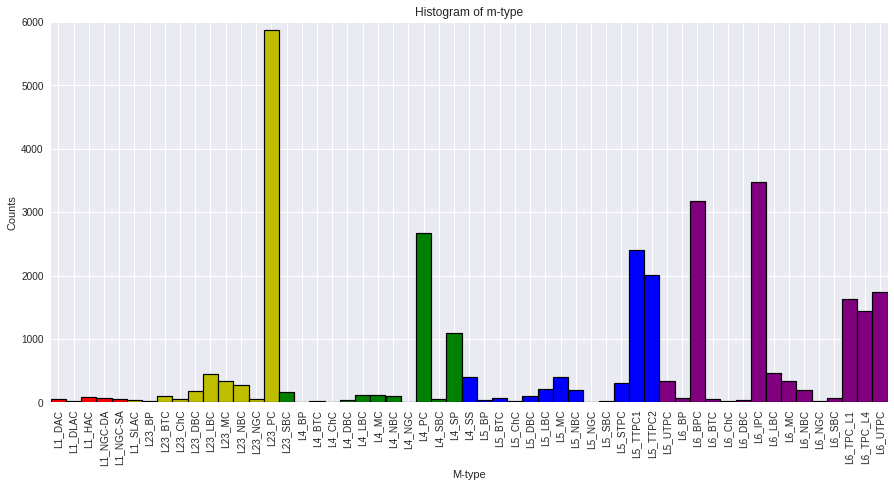

In [12]:
def hist_morpho(label_morpho,a,b,y,title='Histogram of m-type'):
  fig = plt.figure(figsize=(a,b))
  ax=fig.add_subplot(1,1,1)
  n, my_bins, patches = ax.hist(label_morpho, bins=np.arange(-0.5,55,1), facecolor='b',edgecolor='black', linewidth=1.2)

  plt.xlabel('M-type')
  plt.ylabel('Counts')
  plt.title(title)
  plt.axis([-0.5, 54.5, -0.01, y])
  plt.grid(True)

  ax.set_xticks(np.linspace(0,54,55))
  ax.set_xticklabels(m_values, rotation='vertical')


  for i in range(0,5):
      patches[i].set_facecolor('r')
  for i in range(5,15):    
    patches[i].set_facecolor('y')
  for i in range(15,27):
      patches[i].set_facecolor('g')
  for i in range(27,40):
      patches[i].set_facecolor('b')
  for i in range(40,55):
      patches[i].set_facecolor('purple')
  plt.show()

hist_morpho(label_morphology,a=15,b=7,y=6000)

The following is an histogram showing the distribution of the neurons in the 6 layers into which the microcolum is divided.

**Note:** M-type in L2 and L3 are not separated. For example, L23_MC is the group of Martinotti cells extending both in layer 2 and 3. Our convention will be to take layer 2 as a layer-label for these neurons.

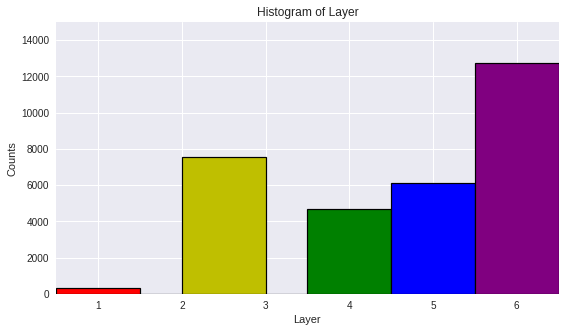

In [13]:
##Distribution of neurons in the 6 lyers

fig = plt.figure(figsize=(9,5))
ax=fig.add_subplot(1,1,1)
n, bins, patches = plt.hist(label_layer,bins=[0.5,1.5,2,3,3.5,4.5,5.5,6.5], facecolor='g',edgecolor='black', linewidth=1.2)
plt.xlabel('Layer')
plt.ylabel('Counts')
plt.title('Histogram of Layer')
plt.axis([0.5, 6.5, 0, 15000])



patches[0].set_facecolor('r')
patches[2].set_facecolor('y')
patches[4].set_facecolor('g')
patches[5].set_facecolor('b')
patches[6].set_facecolor('purple')
    

plt.grid(True)
plt.show()


In [14]:
print('There are {:.0f} in layer 1'.format(n[0]))
print('There are {:.0f} in layer 2-3'.format(n[1]))
print('There are {:.0f} in layer 4'.format(n[3]))
print('There are {:.0f} in layer 5'.format(n[4]))
print('There are {:.0f} in layer 6'.format(n[5]))
print('{:.2%} of all the neurons are located in the 6th layer.'.format(n[6]/N))

There are 338 in layer 1
There are 0 in layer 2-3
There are 0 in layer 4
There are 4656 in layer 5
There are 6114 in layer 6
40.56% of all the neurons are located in the 6th layer.


In the provided file one finds for every neuron the number of neurons which are sending and receiving signals from or to it. The number of afferent (in-degree) and efferent (out-degree) connected neurons are respectivly contained in 'nCellAff' and 'nCellEff'. Two connected neurons can form multiple connections (synapses). Therefore, for a given neuron the values 'nSynAff' and 'nSynEff' count with multiplicity the total number of afferent and efferent connections.

In [15]:
print('The number of afferent connections of the first neuron in -L4_PC- neurons is {}'.format(list(h5['populations'][ 'L4_PC' ]['nCellAff' ][0])[0]))
print('The number of afferent synapses of the first neuron in -L4_PC- neurons is {}'.format(list(h5['populations'][ 'L4_PC' ][ 'nSynAff' ][0])[0]))

The number of afferent connections of the first neuron in -L4_PC- neurons is 427
The number of afferent synapses of the first neuron in -L4_PC- neurons is 1437


**Note:** The number of afferent and efferent connections as well as the number of afferent and efferent synapses data includes some connections from or to neurons outside the microcolum we are considering. The aim of this is to reduce the so called **'edge effect'** or **'border effect'**. That is the effect that neurons at the boundary of the given microcolum have fewer connections. The reason is that a modeled microcircuit is surrounded by other 6 microcircuits and connections from or to these microcircuits are also taken into account in this count.

For example, due the border effect the number of total afferent connections as well as the number of total synapses is not equal respectively to the number of total efferent connections and synapses (in theory, for a given network, one should have total in-degree = total =out degree). Where for total in- respective out-degree we mean the sum of all in-degree over the nodes.


In [16]:
affconn_mtype=[]
effconn_mtype=[]
affsyn_mtype=[]
effsyn_mtype=[]
dist_affconn_mtype=[]
dist_effconn_mtype=[]
dist_affsyn_mtype=[]
dist_effsyn_mtype=[]
for x in m_values:
  dist_affconn_mtype.extend(h5['populations'][ x ]['nCellAff'])
  dist_effconn_mtype.extend(h5['populations'][ x ]['nCellEff'])
  dist_affsyn_mtype.extend((h5['populations'][ x ]['nSynAff']))
  dist_effsyn_mtype.extend((h5['populations'][ x ]['nSynEff']))
  affconn_mtype.append(np.sum(np.array(h5['populations'][ x ]['nCellAff'])))
  effconn_mtype.append(np.sum(np.array(h5['populations'][ x ]['nCellEff'])))
  affsyn_mtype.append(np.sum(np.array(h5['populations'][ x ]['nSynAff'])))
  effsyn_mtype.append(np.sum(np.array(h5['populations'][ x ]['nSynEff'])))
tot_effconn=np.sum(effconn_mtype)
tot_affconn=np.sum(affconn_mtype)
tot_affsyn=np.sum(affsyn_mtype)
tot_effsyn=np.sum(effsyn_mtype)
print('The total number of afferent connections (counting also connection formed outside our volume) is {}'.format(tot_affconn))
print('The total number of efferent connections (counting also connection formed outside our volume) is {}'.format(tot_effconn))
print('The total number of afferent synapses (counting also synapses formed outside our volume) is {}'.format(tot_affsyn))
print('The total number of efferent synapses (counting also synapses formed outside our volume) is {}'.format(tot_effsyn))


The total number of afferent connections (counting also connection formed outside our volume) is 14132808
The total number of efferent connections (counting also connection formed outside our volume) is 14163526
The total number of afferent synapses (counting also synapses formed outside our volume) is 60992747
The total number of efferent synapses (counting also synapses formed outside our volume) is 61100755


In [17]:
w=(tot_affsyn/tot_affconn + tot_effsyn/tot_effconn)/2
print('On average one connection between two neuron is formed by ~{} synapses'.format(w))

On average one connection between two neuron is formed by ~4.314817906598872 synapses


If one wants to look only at the inner connectivity of the selected microcolumn, the 'connectivity' key contains the binary connection matrix. This matrix is splitted into submatrices labeled first by the name of the morphological type of the source of the signal (pre-synaptic neurons), then to the morphological type of the sink of the signal (the post-synaptic neurons). 





For an example in the following we are looking at the connectivity matrix from L4_MC to L4_PC neurons:


In [18]:
conn=np.array(h5['connectivity']['L4_MC']['L4_PC']['cMat'])
print('The connectivity matrix from L4_MC to L4_PC has size {}'.format(conn.shape))  

The connectivity matrix from L4_MC to L4_PC has size (118, 2674)


In [19]:
conn2=np.array(h5['connectivity']['L4_PC']['L4_MC']['cMat'])
print('The connectivity matrix from L4_PC to L4_MC has size {}'.format(conn2.shape))  

The connectivity matrix from L4_PC to L4_MC has size (2674, 118)


## 1.2)Network Building

### Concatenate all the cMat matrices
** Note **: the network we'll build using 'cMat' is directed as h5['connectivity'][x][y]['cMat'] is the adjacency matrix detacting if there are outgoing connections from a presynaptic neuron (source of signal) positioned along the first axis of the matrix to a postsynaptic neuron (sink of the signal) positioned along the second axis of the matrix.

Therefore, we'll build a directed adjacency matrix with presynaptic neurons along the raws and postsynaptic neurons along the columns:

In [20]:
#rows are source of the signal, columns are target
for x in m_values: 
  for y in m_values: 
    if y == m_values[0]:
      conn_tot_row=np.array(h5['connectivity'][x][y]['cMat']) 
    else:
      conn_temp_row=np.array(h5['connectivity'][x][y]['cMat'])
      conn_tot_row = np.concatenate((conn_tot_row, conn_temp_row), axis=1)
  if x == m_values[0]:
    conn_tot = conn_tot_row
  else:
    conn_tot = np.concatenate((conn_tot, conn_tot_row), axis=0) 
print('The shape should be #neurons x #neurons = {} x {}, and we have: {}'.format(N,N,conn_tot.shape) )   

The shape should be #neurons x #neurons = 31346 x 31346, and we have: (31346, 31346)


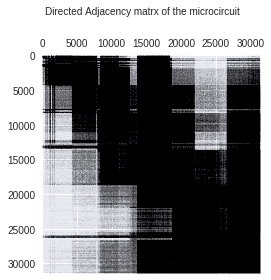

In [21]:
#Plot the adjacency matrix
plt.figure(figsize=(10,4))
plt.subplot(1, 1, 1)
M = sps.csr_matrix(conn_tot)
plt.spy(M, markersize = 0.1, color = 'black')
plt.suptitle('Directed Adjacency matrx of the microcircuit', y=1.05,fontsize=10)

plt.show()

In [0]:
G=nx.MultiDiGraph()
G=nx.from_numpy_matrix(conn_tot)

In [23]:
print('Our network has {} nodes and a total of {} connections (counting bidirectional edges as one edge).'.format(len(G.nodes()),len(G.edges())))

Our network has 31346 nodes and a total of 7709009 connections (counting bidirectional edges as one edge).


If one wants to transform the directed network into an undirected one, it's possible to symmetrize the matrix in the following way:

In [0]:
#symmetrize conn_tot
#conn_tot_symm=np.maximum( conn_tot, conn_tot.transpose())

## 1.3)Network Analysis and Statistics



In this section we'll show some classical network analysis and statistics on the microcircuit. If not specified, for our analysis, **we are considering  the directed network.**

### ** 1.3.1 Some statistics**

**- What is the average in-degree, out-degree and tot-degree?**

In [25]:
out_degree=np.sum(conn_tot, axis=1)
in_degree=np.sum(conn_tot, axis=0)
tot_degree= out_degree + in_degree
tot_connections=np.sum(tot_degree/2)

av_indegree= np.mean(in_degree)
av_outdegree=np.mean(out_degree)
av_totdegree=np.mean(tot_degree)
print('The number of connections is {:.0f}'.format(tot_connections))
print('The average out-degree = average in-degree is {}'.format(av_outdegree))
print('The average degree is {}'.format(av_totdegree))

The number of connections is 7803528
The average out-degree = average in-degree is 248.94812735277227
The average degree is 497.89625470554455


**- What is the probability of connection inside our micorcicuit?**

In [26]:
p=np.sum(tot_degree)/(N*(N-1))
print('The probability of connection inside our microcircuit is {}'.format(p))


The probability of connection inside our microcircuit is 0.015884391600113082


In [27]:
one_way=conn_tot-conn_tot.T
tot_one_way=np.count_nonzero(one_way)/2
print('Number of one-way edges is: {:.0f} Number of two-ways edges (e.g presence of connection (0,1) and connection (1,0)): {:.0f}'.format(tot_one_way, (tot_connections-tot_one_way)))

Number of one-way edges is: 7614490 Number of two-ways edges (e.g presence of connection (0,1) and connection (1,0)): 189038


**- What is the diameter of our network?**


Due to excessive time of computation, we were not able to compute the diameter of the directed network. Instead, we were able to compute the diameter of the undirected network. The  execution time of algorithm was ~24h.

In [0]:
#symmetrize conn_tot
#conn_tot_symm=np.maximum( conn_tot, conn_tot.transpose())
#diam=nx.diameter(G)

**Result:** The diameter of our network is 5.

** -What is the average paths length of our network?**


The APL is defined as the average number of steps along the shortest paths for all possible pairs of network nodes. It is a measure of the efficiency of information or mass transport on a network. [Source](https://en.wikipedia.org/wiki/Average_path_length). We computed the APL of the directed network.


In [0]:
##Execution time ~24h
#APL = nx.average_shortest_path_length(G)

**Result:** The average path length for the directed network is equal to "2.475062028240122114e+00" and the average path length for the undirected network is equal to ~2.33. An "average" path length is not very easy to interpret as it depends on the choice of statistical models used in addition to being at the macroscopic level. [Source](https://www.quora.com/At-what-age-are-the-average-path-lengths-in-the-brains-neural-network-minimized)

** - What is the size of the giant component in directed network?**

We computed the following code for the undirected graph bacuase nx.connected_component_subgraphs(G) is not implemented for directed types.

In [0]:
##Execution time ~12h
#giant_G = max(nx.connected_component_subgraphs(G), key=len)
#print('Giant component of the G network : {}'.format(len(giant_G.nodes())))
#print('Therefore the network is fully connected')

** Result:** The giant component in the undirected network is of size 31346. 

**- What is the average clustering coefficient of our network?**

We computed the following code for the undirected graph because nx.average_clustering(G) is not implemented for directed types.

In [0]:
#print('Average clustering coefficient of the G network : {}'.format(nx.average_clustering(G)))##we are computing the clustering coefficient of a directed network


**Result:** The average clustering  coefficient of the undirected network is 0.056742203420848264

### ** 1.3.2 Degree Distributions**

Now we'll analyse the the in- and out-degree distributions and how they differ from the distributions given by 'nCellAff' and 'nCellEff' which contains also the connections outside our model. 

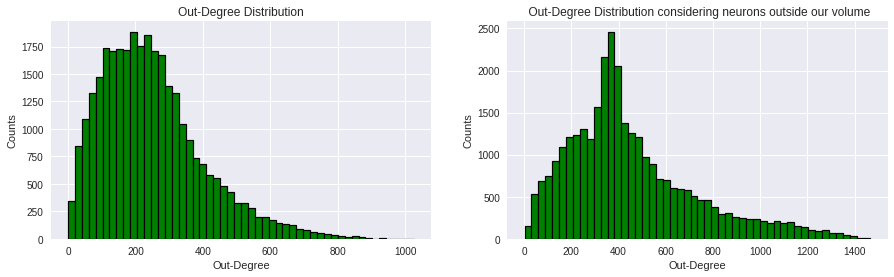

In [31]:
##out degree distribution with border-effect

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
nou, binsou, patchesou = plt.hist(out_degree,bins=50 , facecolor='g',edgecolor='black', linewidth=1.2)
plt.xlabel('Out-Degree')
plt.ylabel('Counts')
plt.title('Out-Degree Distribution')
plt.grid(True)

##out degree distribution without border-effect
plt.subplot(1,2,2)
out_degree_noborder=[]
for i in range(len(dist_effconn_mtype)):
  out_degree_noborder.append(dist_effconn_mtype[i][0])

noubor, binsoubor, patchesoubor = plt.hist(out_degree_noborder,bins=50 , facecolor='g',edgecolor='black', linewidth=1.2)
plt.xlabel('Out-Degree')
plt.ylabel('Counts')
plt.title(' Out-Degree Distribution considering neurons outside our volume')

plt.grid(True)

**- Which are the out-hubs neuron considering only the inner connections?**

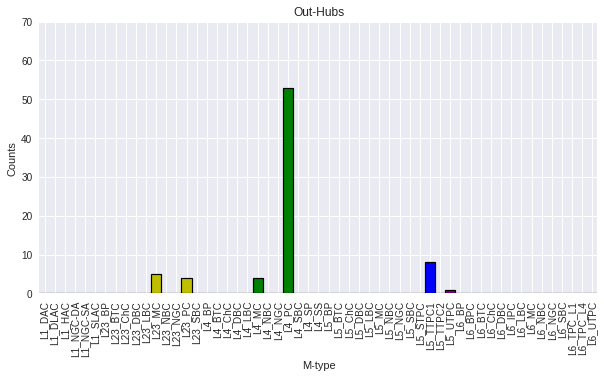

In [32]:
M = binsou[round(len(nou)*0.8)]
out_hubs=[i for i in range(N) if out_degree[i]>M]
oh=[label_morphology[i] for i in out_hubs]
hist_morpho(oh,a=10,b=5,y=70,title='Out-Hubs')

**Results**: Most of the hubs with a very high out degree belong to the morphological type of Pyramidal Cell in layer four. 

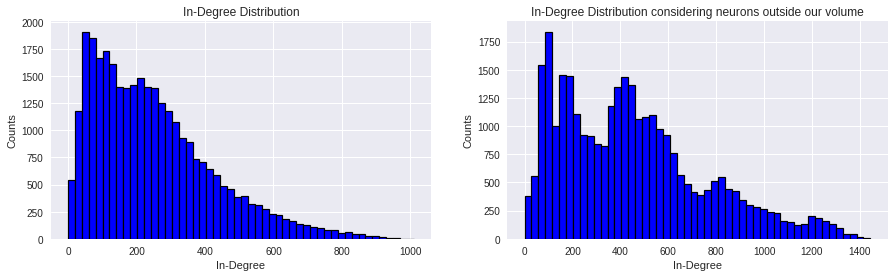

In [33]:
##in degree distribution with border-effect

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
nin, binsin, patchesin = plt.hist(in_degree,bins=50 , facecolor='b',edgecolor='black', linewidth=1.2)
plt.xlabel('In-Degree')
plt.ylabel('Counts')
plt.title('In-Degree Distribution')
plt.grid(True)

##in degree distribution with no border-effect
in_degree_noborder=[]
for i in range(len(dist_affconn_mtype)):
  in_degree_noborder.append(dist_affconn_mtype[i][0])
plt.subplot(1, 2, 2)
ninbor, binsinbor, patchesinbor = plt.hist(in_degree_noborder,bins=50 , facecolor='b',edgecolor='black', linewidth=1.2)
plt.xlabel('In-Degree')
plt.ylabel('Counts')
plt.title('In-Degree Distribution considering neurons outside our volume')

plt.grid(True)


**- Which are the in-hubs neuron considering only the inner connections?**

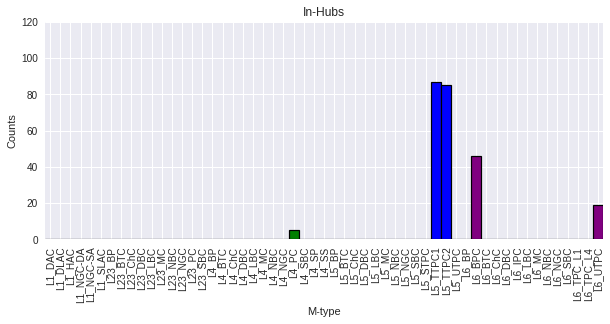

In [34]:
M=binsin[round(len(nou)*0.8)]
in_hubs=[i for i in range(N) if in_degree[i]>M]
ih=[label_morphology[i] for i in in_hubs]
hist_morpho(ih,a=10,b=4,y=120,title='In-Hubs')

**Results**: Most of the hubs with a very high in-degree belong to the morphological type Thick-tufted Pyramidal Cell in layer five. 

Now we will consider the distribution of the nodes degree without taking in account the directionaity: degree+in-deggree+out-degree.

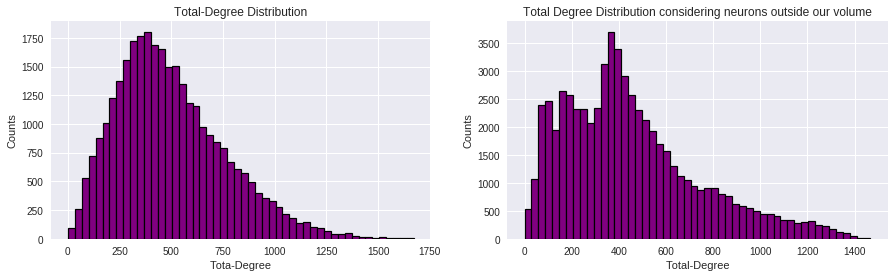

In [35]:
##in degree distribution with border-effect

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
ntot, binstot, patchestot = plt.hist(tot_degree,bins=50 , facecolor='purple',edgecolor='black', linewidth=1.2)
plt.xlabel('Tota-Degree')
plt.ylabel('Counts')
plt.title('Total-Degree Distribution')
plt.grid(True)

#Tot_degree with no border effects
tot_degree_noborder=in_degree_noborder + out_degree_noborder

plt.subplot(1, 2, 2)
ntotbor, binstotbor, patchestotbor = plt.hist(tot_degree_noborder,bins=50 , facecolor='purple',edgecolor='black', linewidth=1.2)
plt.xlabel('Total-Degree')
plt.ylabel('Counts')
plt.title('Total Degree Distribution considering neurons outside our volume')
plt.grid(True)



**- Which are the total-hubs neuron considering only the inner connections?**

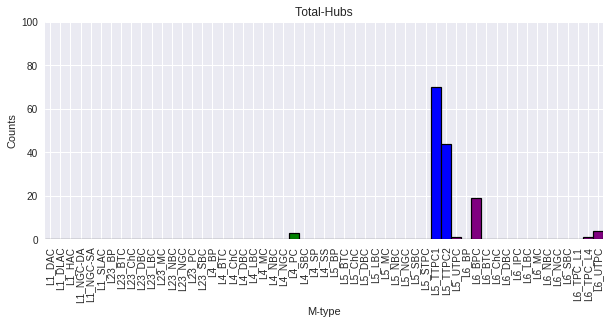

In [36]:
M=binstot[round(len(nou)*0.8)]
tot_hubs=[i for i in range(N) if tot_degree[i]>M]
th=[label_morphology[i] for i in tot_hubs]
hist_morpho(th,a=10,b=4,y=100,title='Total-Hubs')

**Results**: Most of the hubs with a very high total-degree belong to the morphological type Thick-tufted Pyramidal Cell in layer five. 

### **1.3.3 Approximation by random networks models **

**Is our network well approximated by a random graph, that is an Erdős–Rényi (E-R) graph with the same connection probability? **

In [37]:
#creation of the E-R graph
er=nx.erdos_renyi_graph(N, p)
er.size()

7804293

**Comment:** The number of edges of the random graph is what we expect it to be and similar to the one of our network.

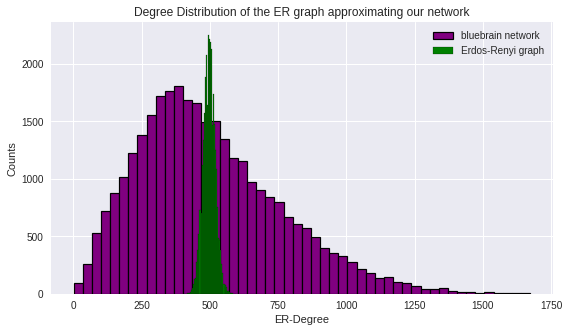

In [38]:
er_degree=er.degree()
er_degree=[er_degree[i] for i in range(0,N)]
fig = plt.figure(figsize=(9,5))
ax=fig.add_subplot(1,1,1)
ntot, binstot, patchestot = plt.hist(tot_degree,bins=50 , facecolor='purple',edgecolor='black', linewidth=1.2)
ner, binser, patcheser = plt.hist(er_degree,bins=50 , facecolor='g',edgecolor='black', linewidth=0.2)
plt.xlabel('ER-Degree')
plt.ylabel('Counts')
plt.title('Degree Distribution of the ER graph approximating our network')
plt.grid(True)
plt.legend(['bluebrain network','Erdos-Renyi graph'])

plt.show()


**Comment:** The microcircuit netwok is not well approximated by the unifrom distribution of an E-R graph with the same connections probability.

In [0]:
#er_dima=nx.diameter(er)

** Result:** The diameter of the Erdos Reny graph is 3.

In [0]:
#er_cc=average_clustering(er)

**Result:** The average clustering coefficient of the Erdős–Rényi graph is 1.588056052869360468e-02

The APL of an Erdős–Rényi graph is given by $ \frac{ln(N)}{ln(K)}\approx 1.68$, in our case. We also computed the exact value:

In [0]:
#APL = nx.average_shortest_path_length(er)

** Result:** The APL is 1.984485.

**Is our network well approximated by a random scale-free network with preferential attachment, namely a Barabasi-Alber graph network?**


In [42]:
#creation of the Barabasi-Albert graph
m=int(av_totdegree/2)
ba= nx.barabasi_albert_graph(N, m)
ba.size()


7712304

**Comment:** The number of edges of the barabasi-albert graph is not exactly the one of our network but still quite similar. 

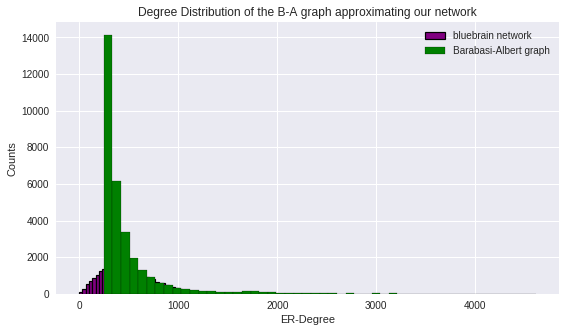

In [43]:
ba_degree=ba.degree()
ba_degree=[ba_degree[i] for i in range(0,N)]
fig = plt.figure(figsize=(9,5))
ax=fig.add_subplot(1,1,1)
ntot, binstot, patchestot = plt.hist(tot_degree,bins=50 , facecolor='purple',edgecolor='black', linewidth=1.2)
nba, binsba, patchesba = plt.hist(ba_degree,bins=50 , facecolor='g',edgecolor='black', linewidth=0.2)
plt.xlabel('ER-Degree')
plt.ylabel('Counts')
plt.title('Degree Distribution of the B-A graph approximating our network')
plt.grid(True)
plt.legend(['bluebrain network','Barabasi-Albert graph'])


plt.show()


**Comment:** The microcircuit netwok is not well approximated by power low distribution of an B-A graph with the same average degree.

In [0]:
#~20h computation
#ba_diam=nx.diameter(ba)

**Result:** The diameter of the Barabasi Albert graph is 3.

In [0]:
#~20h computation
#ba=nx.average_clustering(ba)

**Result:** The average clustering coefficient of the Barabasi Albert Network is 4.775815955795591899e-02

In [0]:
#APL = nx.average_shortest_path_length(ba)

**Result:** The average path length of the B-A network is 1.987421. 

## Summary:

BBP= undirected graph of the microcicuit.

BBP_DI= directed graph of the microcircuit.

ER= Erdős–Rényi graph approximating the microcircuit network.

BA= Barabasi-Albert graph approxmating the microcircuit netwok.

<table class="minimalistBlack">
<thead>
<tr>
<th>Network</th>
<th>APL</th>
<th>Diameter</th>
<th>Clustering Coefficient</th>

</tr>
</thead>
<tbody>
<tr>
<tr>
<td>BBP</td>
<td>2.33</td>
<td>-----5-----  </td>
<td>0.057</td>
</tr>
<tr>
<td>ER</td>
<td>1.98</td>
<td>-----3----- </td>
<td>0.016</td>

</tr>
<tr>
<td>BA</td>
<td>1.99</td>
<td>-----3-----</td>
<td>0.048</td>

</tr>
<tr>
<td>BBP_DI</td>
<td>2.48</td>
<td>----$\varnothing$---- </td>
<td>$\varnothing$</td>
</tr>
</tbody>
</table>

## Conclusion:

Consider the statistics for the undirected connectivity matrix. The network presents a small world property with an average of ~2.3 syanapses separating any two neurons and a maximum of 5 synapses between them. As for scale free networks, it show a low clustering coefficient compered to a E-R network with the same probability of connection. However, the clustering coefficient of our network is smaller than the one of the B-A approximation of the model. In fact, the histogram showing the total degree of the microcircuit doesn't show a power law degree distribution, which characterize scale free networks. Also by not considering the border effect the degree distribution is not a power law distribution.  However, similarly to scale free networks, the microcircuit has a long tails degree distribution, underlying the presence of hubs both in the out-, in- and total-degree distribution. Difference between the scale free network and our model can be found in low degree nodes: in the microcircuit there are much more lower degree nodes than excpected in a B-A network approximating it.


In conclusion the network is not well approximated neither by a E-R network model nor by a B-A network model.
An explanation for this characteristic could be given by the fact that the microcircuit's nodes have a spatial constraint: differently from web and social networks, the neurons are placed in a finite 3d space creating connections based also on their spatial position. This further assumption is taken into consideration for modelling the microcircuit network in ['Rich cell-type-specific network topology in neocortical microcircuitry', (Gal et al. Nature neuroscience, 2017)](https://www.nature.com/articles/nn.4576), where the authors build a distance-dependend random model for approximating the Blue Brain network.
The above mentioned paper contains also exhaustive statistics about the microcolumn network which are consistent with our analysis . 
